In [4]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass

import tensorflow as tf
import tensorflow_datasets as tfds

import matplotlib.pyplot as plt
import numpy as np

2024-06-04 11:41:39.074088: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-04 11:41:39.101868: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
# If you hit a problem with checksums, you can execute the following line first
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=oxford_iiit_pet:3.1.0

# download the dataset and get info
dataset, info = tfds.load('oxford_iiit_pet:3.*.*', with_info=True)

Traceback (most recent call last):
  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "/usr/local/lib/python3.11/dist-packages/tensorflow_datasets/scripts/download_and_prepare.py", line 25, in <module>
    from tensorflow_datasets.scripts.cli import main as main_cli
  File "/usr/local/lib/python3.11/dist-packages/tensorflow_datasets/scripts/cli/main.py", line 37, in <module>
    from tensorflow_datasets.scripts.cli import convert_format
  File "/usr/local/lib/python3.11/dist-packages/tensorflow_datasets/scripts/cli/convert_format.py", line 32, in <module>
    from tensorflow_datasets.scripts.cli import convert_format_utils
  File "/usr/local/lib/python3.11/dist-packages/tensorflow_datasets/scripts/cli/convert_format_utils.py", line 169, in <module>
    pipeline: beam.Pipeline | None = None,
              ^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/etils/epy/lazy_imports_utils.py", line 109, in __getattr__
  

2024-06-04 11:41:44.638757: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 11:41:44.646810: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-06-04 11:41:44.648398: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [6]:
# see the possible keys we can access in the dataset dict.
# this contains the test and train splits.
print(dataset.keys())

dict_keys(['train', 'test'])


In [7]:
class Preproccessing:

    '''
    def __init__(self, input_image, input_mask):

        self.__input_image = input_image
        self.__input_mask = input_mask
    '''
    def random_flip(self, input_image, input_mask):
        '''does a random flip of the image and mask'''
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)

        return input_image, input_mask


    def normalize_img_label(self, input_image, input_mask):
    # tf cast will normnalize image # [0 - 1] range
        norm_image_rgb = tf.cast(input_image, tf.float32) / 255.0
        # mask image
        input_mask -= 1
        
        return norm_image_rgb, input_mask

    @tf.function
    def load_dataset_train(self, datapoint):
        '''resizes, normalizes, and flips the training data'''
        input_image = tf.image.resize(datapoint['image'], (128,128), method='nearest')
        mask_image = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')

        input_image, mask_image = self.random_flip(input_image, mask_image)
        input_image, mask_image = self.normalize_img_label(input_image, mask_image)

        return input_image, mask_image

    def load_dataset_test(self, datapoint):

        input_image = tf.image.resize(datapoint['image'], (128, 128), method='nearest')
        mask_image = tf.image.resize(datapoint['segmentation_mask'], (128, 128), method='nearest')
        # only apply normalization
        input_image, mask_image = self.normalize_img_label(input_image, mask_image)

        return input_image, mask_image

        

In [8]:
preprocessing = Preproccessing()
train = dataset['train'].map(preprocessing.load_dataset_train, num_parallel_calls = tf.data.experimental.AUTOTUNE)
test =  dataset['test'].map(preprocessing.load_dataset_test)

In [9]:
batch_size = 64
buffer_size=1000
# shuffle and group the train set into batches
train_dataset  = train.cache().shuffle(buffer_size).batch(batch_size).repeat()

# do a prefetch to optimize processing
train_dataset = train_dataset.prefetch(buffer_size = tf.data.experimental.AUTOTUNE)


# group the test set into batches
test_dataset = test.batch(batch_size)


In [10]:
# class list of the mask pixels
class_names = ['pet', 'background', 'outline']


def display_with_metrics(display_list, iou_list, dice_score_list):
  '''displays a list of images/masks and overlays a list of IOU and Dice Scores'''

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  display(display_list, ["Image", "Predicted Mask", "True Mask"], display_string=display_string)


def display(display_list,titles=[], display_string=None):
  '''displays a list of images/masks'''

  plt.figure(figsize=(15, 15))

  for i in range(len(display_list)):
    plt.subplot(1, len(display_list), i+1)
    plt.title(titles[i])
    plt.xticks([])
    plt.yticks([])
    if display_string and i == 1:
      plt.xlabel(display_string, fontsize=12)
    img_arr = tf.keras.preprocessing.image.array_to_img(display_list[i])
    plt.imshow(img_arr)

  plt.show()


def show_image_from_dataset(dataset):
  '''displays the first image and its mask from a dataset'''

  for image, mask in dataset.take(1):
    sample_image, sample_mask = image, mask
  display([sample_image, sample_mask], titles=["Image", "True Mask"])


def plot_metrics(metric_name, title, ylim=5):
  '''plots a given metric from the model history'''
  plt.title(title)
  plt.ylim(0,ylim)
  plt.plot(model_history.history[metric_name],color='blue',label=metric_name)
  plt.plot(model_history.history['val_' + metric_name],color='green',label='val_' + metric_name)

2024-06-04 11:41:56.784998: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


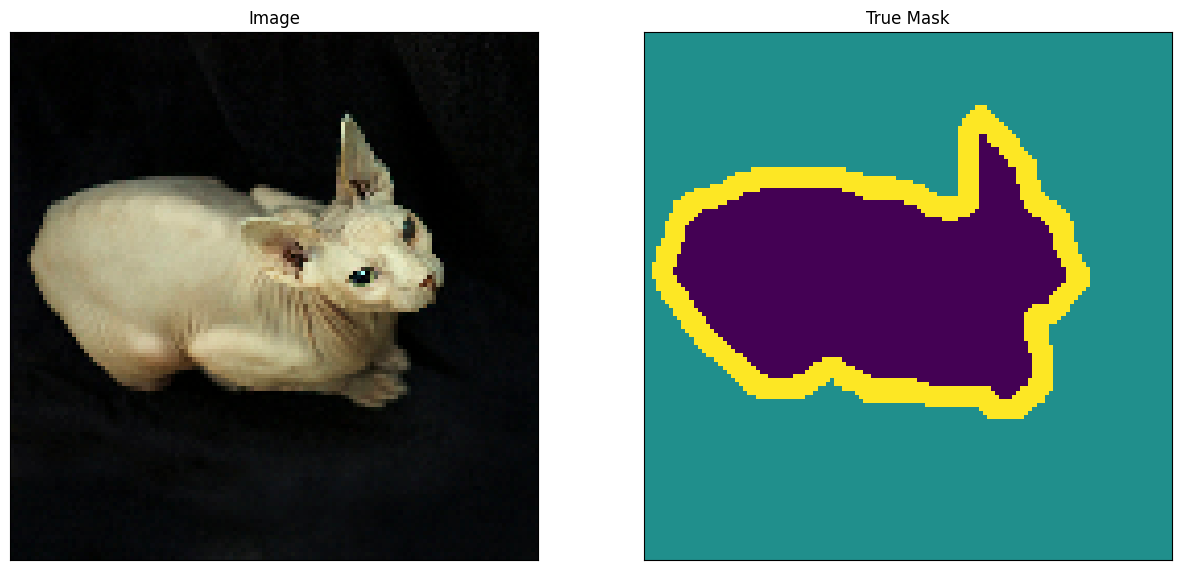

2024-06-04 11:41:56.926094: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


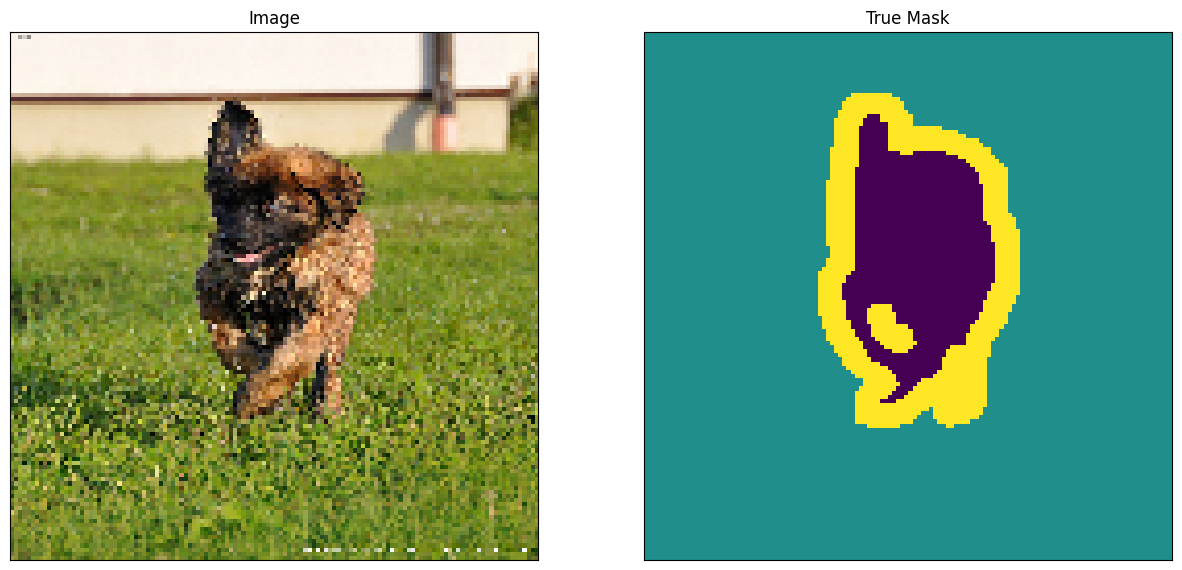

In [11]:
# display an image from the train set
show_image_from_dataset(train)

# display an image from the test set
show_image_from_dataset(test)

In [12]:
class FiltersInterface:

    def __init__(self,filters_1, filters_2, filters_3, filters_4):
        self.filters_1 = filters_1
        self.filters_2 = filters_2
        self.filters_3 = filters_3
        self.filters_4 = filters_4


class UnetScratchEncoder(FiltersInterface):

    def __init__(self, filters_1, filters_2, filters_3, filters_4, pool_size, dropout):
        super().__init__(filters_1, filters_2, filters_3, filters_4)
        
        self.pool_size = pool_size
        self.dropout = dropout

    # first layer
    def conv2d_block(self, input_tensor, n_filters, kernel_size=3):
        '''
          Adds 2 convolutional layers with the parameters passed to it
        
          Args:
            input_tensor (tensor) -- the input tensor
            n_filters (int) -- number of filters
            kernel_size (int) -- kernel size for the convolution
        
          Returns:
            tensor of output features
        '''
        x = input_tensor
        for i in range(2):
            x = tf.keras.layers.Conv2D(filters = n_filters, kernel_size=(kernel_size,kernel_size), \
                                      kernel_initializer='he_normal', padding='same')(x)
            x = tf.keras.layers.Activation('relu')(x)
        return x


    def encoder_block(self, inputs, n_filters, pool_size, dropout=0.3):
        '''
          Adds two convolutional blocks and then perform down sampling on output of convolutions.
        
          Args:
            input_tensor (tensor) -- the input tensor
            n_filters (int) -- number of filters
            pool_size (int, int) -- size of the pooling layer
            dropout (float) -- between 0 and 1. rate of the dropout layer
        
          Returns:
            f - the output features of the convolution block
            p - the maxpooled features with dropout
        '''

        f = self.conv2d_block(inputs, n_filters=n_filters)
        p = tf.keras.layers.MaxPool2D(pool_size=pool_size)(f)
        p= tf.keras.layers.Dropout(rate=dropout)(p)

        # return f for decoder usage
        return f, p

    def encoder_final(self, inputs):
        '''
          This function defines the encoder or downsampling path.
        
          Args:
            inputs (tensor) -- batch of input images
        
          Returns:
            p4 - the output maxpooled features of the last encoder block
            (f1, f2, f3, f4) - the output features of all the encoder blocks
        '''

        f1, p1 = self.encoder_block(inputs, n_filters = self.filters_1, pool_size=self.pool_size, dropout=self.dropout)
        f2, p2 = self.encoder_block(p1, n_filters =  self.filters_2, pool_size=self.pool_size, dropout=self.dropout)
        f3, p3 = self.encoder_block(p2, n_filters =  self.filters_3, pool_size=self.pool_size, dropout=self.dropout)
        f4, p4 = self.encoder_block(p3, n_filters = self.filters_4, pool_size = self.pool_size, dropout=self.dropout)
        return p4, (f1, f2, f3, f4)
        

In [13]:
class BottleneckParams(UnetScratchEncoder):
    '''
      This function defines the bottleneck convolutions to extract more features before the upsampling layers.
    '''
    def init_bottleneck(self, inputs):
      
        bottle_neck = self.conv2d_block(inputs, n_filters=1024)
    
        return bottle_neck
        

In [14]:
class Decoder(UnetScratchEncoder):

    
    def decoder_block(self, inputs, conv_output, n_filters=64, kernel_size=3, strides=3, dropout=0.3):
      '''
      defines the one decoder block of the UNet
    
      Args:
        inputs (tensor) -- batch of input features
        conv_output (tensor) -- features from an encoder block
        n_filters (int) -- number of filters
        kernel_size (int) -- kernel size
        strides (int) -- strides for the deconvolution/upsampling
        dropout (float) -- between 0 and 1. rate of the dropout layer
    
      Returns:
        c (tensor) -- output features of the decoder block
      '''
      u = tf.keras.layers.Conv2DTranspose(n_filters, kernel_size, strides = strides, padding = 'same')(inputs)
      c = tf.keras.layers.concatenate([u, conv_output])
      c = tf.keras.layers.Dropout(dropout)(c)
      c = self.conv2d_block(c, n_filters, kernel_size=3)
    
      return c
    
    
    def decoder(self, inputs, convs, output_channels):
      '''
      Defines the decoder of the UNet chaining together 4 decoder blocks.
    
      Args:
        inputs (tensor) -- batch of input features
        convs (tuple) -- features from the encoder blocks
        output_channels (int) -- number of classes in the label map
    
      Returns:
        outputs (tensor) -- the pixel wise label map of the image
      '''
    
      f1, f2, f3, f4 = convs
    
      c6 = self.decoder_block(inputs, f4, n_filters=self.filters_4, kernel_size=(3,3), strides=(2,2), dropout=0.3)
      c7 = self.decoder_block(c6, f3, n_filters=self.filters_3, kernel_size=(3,3), strides=(2,2), dropout=0.3)
      c8 = self.decoder_block(c7, f2, n_filters=self.filters_2, kernel_size=(3,3), strides=(2,2), dropout=0.3)
      c9 = self.decoder_block(c8, f1, n_filters=self.filters_1, kernel_size=(3,3), strides=(2,2), dropout=0.3)
    
      outputs = tf.keras.layers.Conv2D(output_channels, (1, 1), activation='softmax')(c9)
    
      return outputs
        

In [15]:
unet_init = UnetScratchEncoder(64, 128, 256, 512,pool_size=(2,2), dropout=0.3)



In [16]:
bottleneck = BottleneckParams(64, 128, 256, 512,pool_size=(2,2),dropout=0.3)


In [17]:
decoder_ob = Decoder(64, 128, 256, 512, pool_size=(2, 2), dropout=0.3)

In [18]:
OUTPUT_CHANNELS = 3

def main():
  '''
  Defines the UNet by connecting the encoder, bottleneck and decoder.
  '''
  
  # specify the input shape
  inputs = tf.keras.layers.Input(shape=(128, 128,3,))

  # feed the inputs to the encoder
  encoder_output, convs = unet_init.encoder_final(inputs)

  # feed the encoder output to the bottleneck
  bottle_neck =bottleneck.init_bottleneck(encoder_output)

  # feed the bottleneck and encoder block outputs to the decoder
  # specify the number of classes via the `output_channels` argument
    # 3 classes
  outputs = decoder_ob.decoder(bottle_neck, convs, output_channels=OUTPUT_CHANNELS)

  # create the model
  model = tf.keras.Model(inputs=inputs, outputs=outputs)

  return model


if __name__=="__main__":
    # instantiate the model
    model = main()
    # see the resulting model architecture
    model.summary()



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 128, 128,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 128, 128,  │          0 │ conv2d[0][0]      │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 128, 128,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 128, 128,  │          0 │ conv2d_1[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 64, 64,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 64, 64,    │          0 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 64, 64,    │     73,856 │ dropout[0][0]     │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 64, 64,    │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 64, 64,    │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 64, 64,    │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 32, 32,    │          0 │ max_pooling2d_1[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │    295,168 │ dropout_1[0][0]   │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (None, 32, 32,    │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 32, 32,    │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 32, 32,    │          0 │ conv2d_5[0][0]  

 Total params: 34,513,475 (131.66 MB)

 Trainable params: 34,513,475 (131.66 MB)

 Non-trainable params: 0 (0.00 B)

In [19]:
# configure the optimizer, loss and metrics for training
model.compile(optimizer=tf.keras.optimizers.Adam(), loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [33]:
steps_per_epochs = train_l

In [20]:
# configure the training parameters and train the model

TRAIN_LENGTH = info.splits['train'].num_examples
EPOCHS = 10
VAL_SUBSPLITS = 5
STEPS_PER_EPOCH = TRAIN_LENGTH // batch_size
VALIDATION_STEPS = info.splits['test'].num_examples//batch_size//VAL_SUBSPLITS

# this will take around 20 minutes to run
model_history = model.fit(train_dataset, epochs=EPOCHS,
                          steps_per_epoch=STEPS_PER_EPOCH,
                          validation_steps=VALIDATION_STEPS,
                          validation_data=test_dataset)

Epoch 1/10


Corrupt JPEG data: 240 extraneous bytes before marker 0xd9
Corrupt JPEG data: premature end of data segment
I0000 00:00:1717501329.807390    9962 service.cc:145] XLA service 0x7f6a0000a3d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1717501329.807412    9962 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-06-04 11:42:09.896372: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1717501330.033629    9962 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-06-04 11:42:10.212518: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8906
I0000 00:00:1717501365.566017    9962 device_compiler.h:188] Compiled cluster using XLA!  This line 

57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step - accuracy: 0.5600 - loss: 0.9721

W0000 00:00:1717501380.179295    9969 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert


57/57 ━━━━━━━━━━━━━━━━━━━━ 54s 273ms/step - accuracy: 0.5603 - loss: 0.9710 - val_accuracy: 0.6377 - val_loss: 0.8024
Epoch 2/10


W0000 00:00:1717501381.292979    9962 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-06-04 11:43:07.858901: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.09GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.
2024-06-04 11:43:08.825995: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.06GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


57/57 ━━━━━━━━━━━━━━━━━━━━ 37s 262ms/step - accuracy: 0.6529 - loss: 0.7762 - val_accuracy: 0.7185 - val_loss: 0.7019
Epoch 3/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 260ms/step - accuracy: 0.7337 - loss: 0.6601 - val_accuracy: 0.7548 - val_loss: 0.6095
Epoch 4/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.7657 - loss: 0.5899 - val_accuracy: 0.7901 - val_loss: 0.5323
Epoch 5/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 261ms/step - accuracy: 0.7891 - loss: 0.5395 - val_accuracy: 0.8215 - val_loss: 0.4616
Epoch 6/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step - accuracy: 0.8154 - loss: 0.4758

W0000 00:00:1717501477.362313    9962 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-06-04 11:44:40.941385: W external/local_tsl/tsl/framework/bfc_allocator.cc:296] Allocator (GPU_0_bfc) ran out of memory trying to allocate 5.37GiB with freed_by_count=0. The caller indicates that this is not a failure, but this may mean that there could be performance gains if more memory were available.


57/57 ━━━━━━━━━━━━━━━━━━━━ 18s 321ms/step - accuracy: 0.8155 - loss: 0.4755 - val_accuracy: 0.8155 - val_loss: 0.4985
Epoch 7/10


2024-06-04 11:44:41.210165: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-06-04 11:44:41.210197: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_4]]
2024-06-04 11:44:41.210204: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 15914715277131204990
2024-06-04 11:44:41.210208: I tensorflow/core/framework/local_rendezvous.cc:422] Local rendezvous recv item cancelled. Key hash: 3289721084031566382
/usr/lib/python3.11/contextlib.py:155: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, trac

57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 265ms/step - accuracy: 0.8221 - loss: 0.4631 - val_accuracy: 0.8387 - val_loss: 0.4166
Epoch 8/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 262ms/step - accuracy: 0.8398 - loss: 0.4163 - val_accuracy: 0.8543 - val_loss: 0.3811
Epoch 9/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 263ms/step - accuracy: 0.8450 - loss: 0.4059 - val_accuracy: 0.8433 - val_loss: 0.3996
Epoch 10/10
57/57 ━━━━━━━━━━━━━━━━━━━━ 15s 264ms/step - accuracy: 0.8602 - loss: 0.3641 - val_accuracy: 0.8497 - val_loss: 0.3940


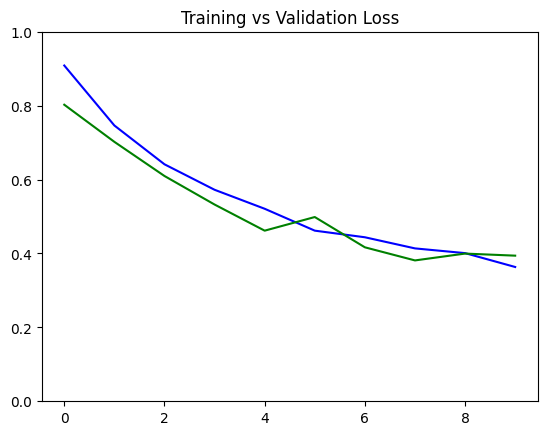

In [21]:
# Plot the training and validation loss
plot_metrics("loss", title="Training vs Validation Loss", ylim=1)

In [38]:
 ds = test_dataset.unbatch()
 ds = ds.batch(info.splits['test'].num_examples)

<_BatchDataset element_spec=(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 128, 128, 1), dtype=tf.uint8, name=None))>

In [41]:
# Prediction Utilities

def get_test_image_and_annotation_arrays():
  '''
  Unpacks the test dataset and returns the input images and segmentation masks
  '''

  ds = test_dataset.unbatch()
  ds = ds.batch(info.splits['test'].num_examples)

  images = []
  y_true_segments = []

  for image, annotation in ds.take(1):
    y_true_segments = annotation.numpy()
    images = image.numpy()

  y_true_segments = y_true_segments[:(info.splits['test'].num_examples - (info.splits['test'].num_examples % batch_size))]

  return images[:(info.splits['test'].num_examples - (info.splits['test'].num_examples %  batch_size))], y_true_segments


def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  print(pred_mask)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [44]:

def create_mask(pred_mask):
  '''
  Creates the segmentation mask by getting the channel with the highest probability. Remember that we
  have 3 channels in the output of the UNet. For each pixel, the predicition will be the channel with the
  highest probability.
  '''
  pred_mask = tf.argmax(pred_mask, axis=-1)
  pred_mask = pred_mask[..., tf.newaxis]
  return pred_mask[0].numpy()


def make_predictions(image, mask, num=1):
  '''
  Feeds an image to a model and returns the predicted mask.
  '''

  image = np.reshape(image,(1, image.shape[0], image.shape[1], image.shape[2]))
  pred_mask = model.predict(image)
  print(pred_mask)
  pred_mask = create_mask(pred_mask)

  return pred_mask

In [45]:
# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

2024-06-04 13:20:58.342095: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [46]:
y_true_images.shape

(3648, 128, 128, 3)

In [47]:
# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//batch_size)

57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


In [52]:
results.shape

(3648, 128, 128)

In [42]:
def class_wise_metrics(y_true, y_pred):
  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001
  for i in range(3):

    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [43]:
# Setup the ground truth and predictions.

# get the ground truth from the test set
y_true_images, y_true_segments = get_test_image_and_annotation_arrays()

# feed the test set to th emodel to get the predicted masks
results = model.predict(test_dataset, steps=info.splits['test'].num_examples//batch_size)
results = np.argmax(results, axis=3)
results = results[..., tf.newaxis]

 3/57 ━━━━━━━━━━━━━━━━━━━━ 3s 66ms/step

2024-06-04 12:13:25.481472: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


57/57 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step


In [29]:
# compute the class wise metrics
cls_wise_iou, cls_wise_dice_score = class_wise_metrics(y_true_segments, results)

In [30]:
# show the IOU for each class
for idx, iou in enumerate(cls_wise_iou):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, iou))

pet         0.7200274020669621 
background  0.8437714854342176 
outline     0.3699201699798764 


In [31]:
# show the Dice Score for each class
for idx, dice_score in enumerate(cls_wise_dice_score):
  spaces = ' ' * (10-len(class_names[idx]) + 2)
  print("{}{}{} ".format(class_names[idx], spaces, dice_score))


pet         0.8372278269542585 
background  0.9152668778101063 
outline     0.5400609146234002 


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


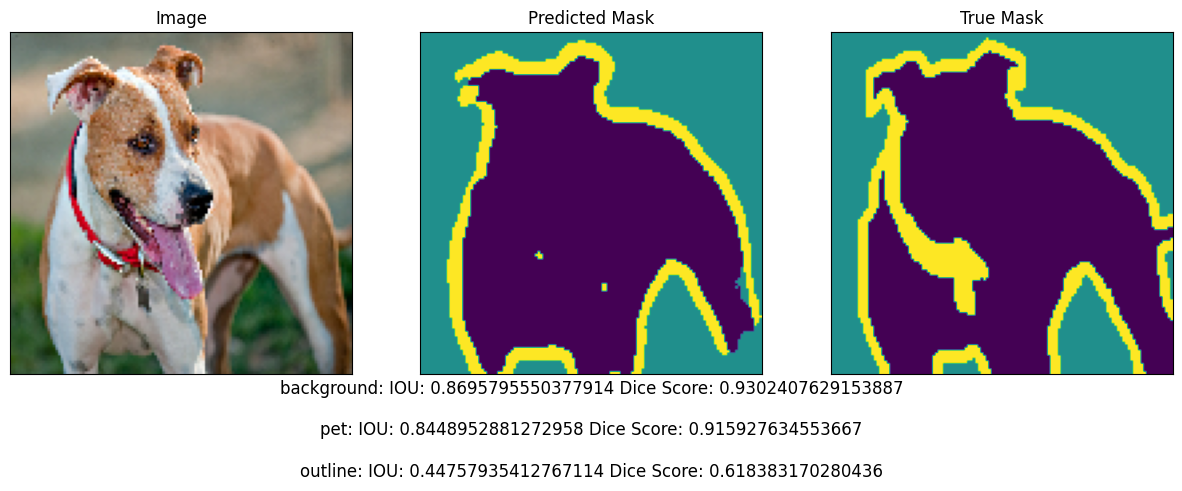

In [32]:
# Please input a number between 0 to 3647 to pick an image from the dataset
integer_slider = 3646

# Get the prediction mask
y_pred_mask = make_predictions(y_true_images[integer_slider], y_true_segments[integer_slider])

# Compute the class wise metrics
iou, dice_score = class_wise_metrics(y_true_segments[integer_slider], y_pred_mask)

# Overlay the metrics with the images
display_with_metrics([y_true_images[integer_slider], y_pred_mask, y_true_segments[integer_slider]], iou, dice_score)